In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. This dataset contains 277,483 96x96 pixel pathology images with a binary label: positive if at least one pixel in the center 32x32 pixels of the image contains tumor tissue, 0 otherwise. The data is split into 220025 image-label pairs for model implementation (i.e. split into training and validation), with 57458 image-label pairs to assess the dataset on. The goal is to train a model to classify the pathology images with the maximum area under the ROC curve between predicted probability and observed target.

In [2]:
#Load and sort the code into train and test images and labels
train_dir = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
test_dir = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

train_tif_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_tif_dir = '/kaggle/input/histopathologic-cancer-detection/test'

df_train = pd.read_csv(train_dir)
df_test = pd.read_csv(test_dir)
#In order to overcome memory issues, I used data loading from https://www.kaggle.com/code/ivandavidruizangel/ivandruiza-histological-classifier-cnn
df_train['path'] = train_tif_dir + '/' + df_train['id'] + '.tif'
df_train['path'] = df_train['path'].astype(str)
df_test['path'] = test_tif_dir + '/' + df_test['id'] + '.tif'
df_test['path'] = df_test['path'].astype(str)
#train_data, validate_data = train_test_split(df_train, test_size = 0.25, random_state=31)
df_train['label'] = df_train['label'].astype(str)
#y_validate = validate_data['label']
df_test['label'] = df_test['label'].astype(str)

X_train_name = df_train['id']
X_train_img = []

print(df_train['path'][0])

#Wrong_Size = 0
#for i in range(len(X_train_name)):
#    image_temp = img.imread(train_tif_dir + '/' + X_train_name[i] + '.tif')[16:79][16:79][0:2]
#    image_temp = np.float16(image_temp)
#    X_train_img.append(image_temp)
    #X_train_img[i] = X_train_img[i]/255
#    if np.shape(X_train_img[i]) != (64,64,3):
#        Wrong_Size += 1

/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif


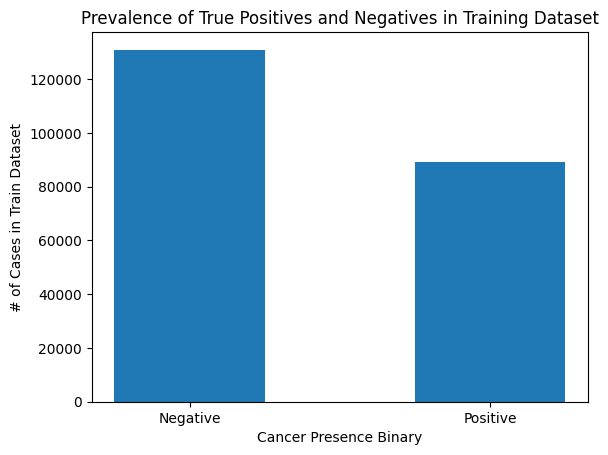

In [3]:
        
#for i in range(len(X_validate_name)):
#    X_validate_img.append(img.imread(train_tif_dir + '/' + X_validate_name[i] + '.tif'))
#    #X_train_img[i] = X_train_img[i]/255
#    if np.shape(X_validate_img[i]) != (96,96,3):
#        Wrong_Size += 1
        
#X_test_name = df_test['id']
#X_test_img = []
#for i in range(len(X_test_name)):
#    image_temp = img.imread(test_tif_dir + '/' + X_test_name[i] + '.tif')[16:79][16:79][0:2]
#    image_temp = np.float16(image_temp)
#    X_test_img.append(image_temp)
#    #X_test_img[i] = X_test_img[i]/255
#    if np.shape(X_test_img[i]) != (64,64,3):
#        Wrong_Size += 1

#print('# Of images that are the wrong size: ' + str(Wrong_Size))


plt.hist(df_train['label'], 3)
plt.xlabel('Cancer Presence Binary')
plt.xticks(ticks=[0.1667,0.8333],labels=['Negative','Positive'])
plt.ylabel('# of Cases in Train Dataset')
plt.title('Prevalence of True Positives and Negatives in Training Dataset')

#plt.hist(y_validate, 3)
#plt.xlabel('Cancer Presence Binary')
#plt.xticks(ticks=[0.1667,0.8333],labels=['Negative','Positive'])
#plt.ylabel('# of Cases in Train Dataset')
#plt.title('Prevalence of True Positives and Negatives in Validation Dataset')


plt.show()

In [1]:
#Positive = 0
#Negative = 0
#for i in range(len(X_train_name)):
#    Mis_labeled = 0
#    if df_train['label'][i] != str(1):
#        Negative += 1
#        if df_train['label'][i] != str(0):
#            Mis_labeled += 1
            #print(i)
#    else:
#        Positive += 1


#for i in range(len(X_validate_name)):
#    Mis_labeled = 0
#    if y_validate[i] != 1:
#        Negative_validate += 1
#        if y_validate[i] != 0:
#            Mis_labeled += 1
#    else:
#        Positive_validate += 1

#Pos_prop_train = Positive/(Positive+Negative)
##Pos_prop_validate = Positive/(Positive+Negative)
##print(df_train['label'][0])
#print('# of Mislabeled Images = ' + str(Mis_labeled))
#print('Proportion of Positive train images = ' + str(Pos_prop_train))
#print('Proportion of Positive validate images = ' + str(Neg_prop))

At this point the data itself is very clean with all labels are 0 or 1 and all images are 96x96x3, with the 3rd dimension being RGB channels. This was checked in a previous run since the training time was extensive and Kaggle would restart without finishing training if I didn't comment it out.

There are an unequal # of positive and negative labels, so the accuracy must exceed 0.6 to show learning (guess all labels as 0 would produce an accuracy of 0.6). Due to the large # of cases, it can be assumed that there will be a similar proportion of positive and negative cases when split into training and testing.

I plan on doing transfer learning on VGG19, as this model has been shown to produce good results with medical image classification (Comparison of Machine Learning and Deep Learning for View Identification from Cardiac Magnetic Resonance Images Chauhan D et al https://pmc.ncbi.nlm.nih.gov/articles/PMC8849564/). Since the dataset is large, utilizing a pre-trained network is acceptable. I will test epochs from 1-10, select an epoch based on maximum accuracy value predicting the validation datasets. I will then vary the batch size from 256 to 128 to see if the accuracy increases at a trade-off with training time. I will use a SGD optimizer and a loss function of binary cross entropy.

In [6]:
vgg19_weights_path = '/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = VGG19(weights=vgg19_weights_path, include_top=False, input_shape=(96,96,3)) #Makes pre-trained VGG model without layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128, activation ='relu')(x)
prediction = Dense(1, activation='sigmoid')(x) #Single output node for scores 0 or 1

model = Model(inputs=base_model.input, outputs=prediction) #Creating model with positive/negative output

for layer in base_model.layers:
    layer.trainable = False #Keeps weights frozen

model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy']) #Compiles model with sgd optimization and Categorical Crossentropy loss function

#Preprocessing of Data as inspired by https://www.kaggle.com/code/ivandavidruizangel/ivandruiza-histological-classifier-cnn due to persistent memory issues
Preprocessed_images = ImageDataGenerator(rescale=1./255, validation_split=0.25)
#Commented out to run straight through, examples output image below
#Train_images = Preprocessed_images.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='label', batch_size=256, subset='training', class_mode='binary', target_size=(96,96), color_mode='rgb', validate_filenames=False)
#Validation_images = Preprocessed_images.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='label', batch_size=256, subset='validation', class_mode='binary', target_size=(96,96), color_mode='rgb', validate_filenames=False)

#Checkpoints to save weights from each epoch from https://datascience.stackexchange.com/questions/85409/getting-nn-weights-for-every-batch-epoch-from-keras-model
#weights_dict = {}
#weight_callback = ModelCheckpoint("/kaggle/working/most_recent_epoch.keras", monitor='loss', save_best_only=False, mode="auto", save_freq='epoch')
#model.fit(x=X_train_img, y = y_train, epochs=25, batch_size=256, validation_split=0.25, callbacks = [weight_callback])
#model.fit(Train_images, validation_data = Validation_images, epochs=10, callbacks=[weight_callback])
#val_loss, val_acc = model.evaluate(X_validate_img, y_validate)
#print('Completed')

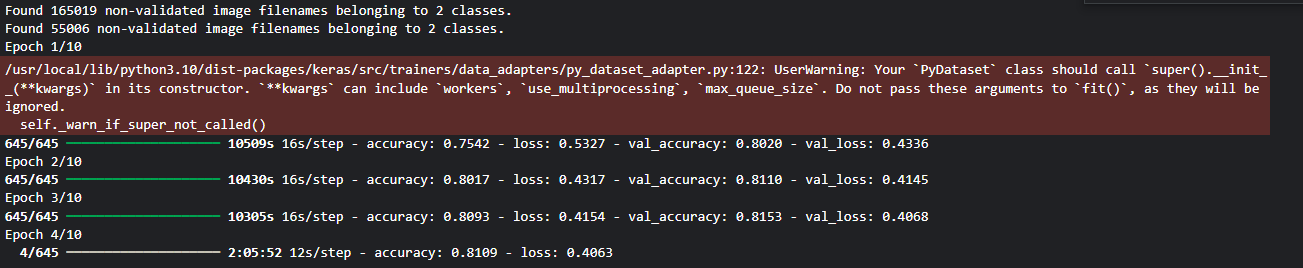

This is the output for the above parameters.

Due to the constraints of Kaggle, 3 epochs of VGG19 seems to be sufficient with a batch size of 256, as validation accuracy only increased .4% from epoch 2 to 3. Now I will attempt to lower the batch size to 128 to see if I can increase accuracy at the expense of increasing training time.

In [7]:
Train_images_bs128 = Preprocessed_images.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='label', batch_size=128, subset='training', class_mode='binary', target_size=(96,96), color_mode='rgb', validate_filenames=False)
Validation_images_bs128 = Preprocessed_images.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='label', batch_size=128, subset='validation', class_mode='binary', target_size=(96,96), color_mode='rgb', validate_filenames=False)
#x_train_data = np.asarray(train_data['id']).astype(np.float32)
#print(x_train_data)
#y_train_data = train_data['label']
#print(y_train_data)
#Training the Model
#print(len(Train_images))
#Checkpoints to save weights from each epoch from https://datascience.stackexchange.com/questions/85409/getting-nn-weights-for-every-batch-epoch-from-keras-model
#weights_dict = {}
weight_callback = ModelCheckpoint("/kaggle/working/most_recent_epoch.keras", monitor='loss', save_best_only=False, mode="auto", save_freq='epoch')
#model.fit(x=X_train_img, y = y_train, epochs=25, batch_size=256, validation_split=0.25, callbacks = [weight_callback])
model.fit(Train_images_bs128, validation_data = Validation_images_bs128, epochs=3, callbacks=[weight_callback])
#val_loss, val_acc = model.evaluate(X_validate_img, y_validate)
print('Completed')

Found 165019 non-validated image filenames belonging to 2 classes.
Found 55006 non-validated image filenames belonging to 2 classes.
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 12638s 10s/step - accuracy: 0.7788 - loss: 0.4853 - val_accuracy: 0.8117 - val_loss: 0.4129
Epoch 2/3
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 12629s 10s/step - accuracy: 0.8108 - loss: 0.4154 - val_accuracy: 0.8172 - val_loss: 0.4024
Epoch 3/3
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 12597s 10s/step - accuracy: 0.8149 - loss: 0.4064 - val_accuracy: 0.8194 - val_loss: 0.3973
Completed


As we can see from the validation accuracy, using a batch size of 128 increased the accuracy of the validation predictions, from 0.8153 to . The trade-off was that training time went from ~8.5 hours to ~10.5. 

I learned through this that while VGG19 is a very good model for image classification, it takes a long time to transfer learn. In the future, I will avoid using VGG19 without a GPU accelerator.

In [9]:
#Create Predictions for Competition as inspired from https://www.kaggle.com/code/ivandavidruizangel/ivandruiza-histological-classifier-cnn
Testing_images = ImageDataGenerator(rescale=1./255)

Test_images = Testing_images.flow_from_dataframe(dataframe=df_test, x_col='path', target_size=(96,96), batch_size=64, class_mode=None, shuffle=False)


y_pred  = model.predict(Test_images)
#y_pred = np.argmax(y_prediction, axis=1)
#y_test = np.argmax()

df_test["y_pred"] = (y_pred >= 0.5).astype(int)

print(df_test.head())

df_test.to_csv("submission.csv", index=False)

Found 57458 validated image filenames.
898/898 ━━━━━━━━━━━━━━━━━━━━ 3246s 4s/step
                                         id label  \
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5     0   
1  95596b92e5066c5c52466c90b69ff089b39f2737     0   
2  248e6738860e2ebcf6258cdc1f32f299e0c76914     0   
3  2c35657e312966e9294eac6841726ff3a748febf     0   
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6     0   

                                                path  y_pred  
0  /kaggle/input/histopathologic-cancer-detection...       0  
1  /kaggle/input/histopathologic-cancer-detection...       0  
2  /kaggle/input/histopathologic-cancer-detection...       0  
3  /kaggle/input/histopathologic-cancer-detection...       0  
4  /kaggle/input/histopathologic-cancer-detection...       0  


In [11]:
df_test.to_csv('D:\Scratch\JG_Module3_Submission_VGG_19', index=False)